
# <font color='green'>Analyse des sentiments</font>

# <font color='red'>Lecture des données</font>
***

#### Importer les bibliothèques

Reportez-vous aux pages Web pour les bibliothèques individuelles
* [pandas] (http://pandas.pydata.org/), pour charger et gérer les données
* [matplotlib] (http://matplotlib.org/), pour la visualisation
* [numpy] (http://www.numpy.org/) pour peindre la représentation et la manipulation
* [re] (https://docs.python.org/3/library/re.html) pour l'expression régulière
* [nltk] (http://www.nltk.org/) pour le prétraitement

In [1]:
import pandas as pd
import re
import scipy
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn import metrics
from sklearn.linear_model import LogisticRegression

%matplotlib inline

#### Lecture de l'ensemble de données
Certaines des données "uploaded_cleansed_B" sont produites à partir de "uploaded_cleansed_A". La différence est:
- "uploaded_cleansed_A" a trois colonnes que nous n'utiliserons pas.
- "uploaded_cleansed_A" a des tweets répété.

In [2]:
df = pd.read_csv('/data/train/downloaded_cleansed_B.tsv', sep= '\t', header=None)
print (df.shape)
df.head()

(9665, 4)


,0,1,2,3
0,264183816548130816,15140428,positive,Gas by my house hit $3.39!!!! I'm going to Cha...
1,263405084770172928,591166521,negative,Not Available
2,262163168678248449,35266263,negative,Not Available
3,264249301910310912,18516728,negative,Iranian general says Israel's Iron Dome can't ...
4,262682041215234048,254373818,neutral,Not Available


Notez que certains tweets sont "Non disponible". Nous les rejetterons car cela n'aidera pas dans l'analyse des sentiments

#### Supprimer tous les tweets "NOT AVAILABLE"

In [3]:
df = df[df[3] != "Not Available"]
df.head()

,0,1,2,3
0,264183816548130816,15140428,positive,Gas by my house hit $3.39!!!! I'm going to Cha...
3,264249301910310912,18516728,negative,Iranian general says Israel's Iron Dome can't ...
6,264105751826538497,147088367,positive,with J Davlar 11th. Main rivals are team Polan...
7,264094586689953794,332474633,negative,"Talking about ACT's &amp;&amp; SAT's, deciding..."
9,254941790757601280,557103111,negative,"They may have a SuperBowl in Dallas, but Dalla..."


In [4]:
df.shape

(7205, 4)

#### Dessiner les données

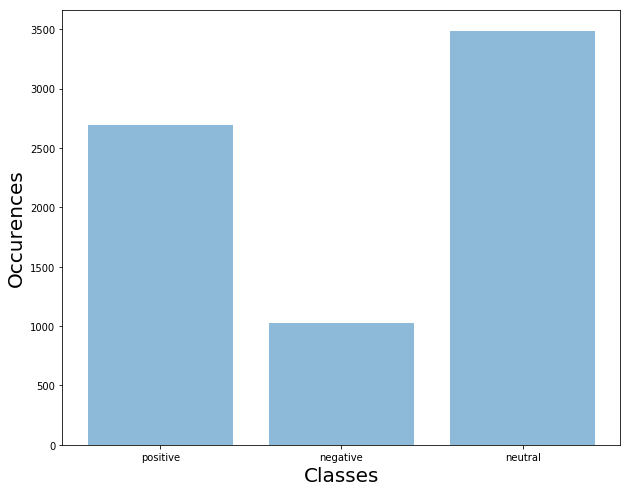

In [5]:
# calculate the total number of occurrences of each class
y = [len(df[df[2] == i]) for i in ['positive', 'negative', 'neutral']]
# X axis
objects = ['positive', 'negative', 'neutral']
x_pos = range(len(objects))

# Draw Diagram
plt.figure(figsize=(10,8))
plt.bar(x_pos, y, alpha=0.5)
plt.xticks(x_pos, objects)
plt.ylabel('Occurences').set_size(20)
plt.xlabel('Classes').set_size(20)

#### Interprétation
À partir du graphique ci-dessus, nous pouvons clairement noter que la classe «négative» a le moins d'échantillons dans les données par rapport à «positif» et «neutre». Par conséquent, les données semblent déséquilibrées.

In [6]:
raw_tweets = list(df[3])
labels = df[2]
mapper = {'positive': 1, 'negative': -1, 'neutral': 0}
labels = labels.map(mapper)
labels.shape

(7205,)

### Sentiment140 Score

Avant de faire un pré-traitement sur les tweets, nous allons d'abord utiliser le score du Sentiment140 corpus. Ce corpus a le score des mots les plus courants (formels, informels) utilisés dans twitter. Le score est un nombre compris entre [-4.999: 4.999].

Le score sera divisé en trois parties:
- unigram score  --> 'unigram140_score'
- bigram score   --> 'bigram140_score'
- pair score     --> 'pair140_score'

In [7]:
def Sentiment140_dictionary(filename):
    sentiment140 = {}
    with open(filename) as fin:
        line = fin.readline()[:-1]
        while line:
            line = line.split('\t')
            sentiment140[line[0]] = float(line[1])
            line = fin.readline()[:-1]
    return sentiment140

unigram140_d = Sentiment140_dictionary('/data/resources/Sentiment140/unigrams-pmilexicon.txt')
hashtag_words = [word for word in unigram140_d.keys() if word[0]=='#']

print(len(hashtag_words))
hashtag_words[:10]

576


['#whocangetit',
 '#t',
 "#ff's",
 '#epicfail',
 '#gratitude',
 '#rejectprop8',
 '#5',
 '#zoeboe',
 '#twitterfail',
 '#votemcfly']

### SemEval2015 English lexicon 

Ce sont les toutes premières et dernières entrées de 'SemEval2015-English-Twitter-Lexicon.txt':
- 0.984	loves
- 0.984	#inspirational
- 0.969	amazing
- 0.969	#peaceful
- 0.953	#greatness
- ...
- -0.969	abuse
- -0.969	#failure
- -0.982	kill
- -0.984	bitches
- -0.984	#disappointment

In [8]:
def loadSemEval(filename):
    f = open(filename,'r')
    lexicon = {}
    line = f.readline()
    while line:
        l = line[:-1].split('\t')
        lexicon[l[1]] = float(l[0])
        line = f.readline()
    return lexicon

EnglishLexicon = loadSemEval('/data/resources/SemEval2015-English-Twitter-Lexicon.txt')
hashtag_words.extend([word for word in EnglishLexicon.keys() if word[0]=='#'])
hashtag_words = set(hashtag_words)
print(len(hashtag_words))
list(hashtag_words)[-10:]

886


['#beijing',
 '#design',
 '#ffoe',
 '#wolverine',
 '#imaddicted',
 '#poker',
 '#haiku',
 '#wtf',
 '#rant',
 '#windows']

***
# <font color='red'>Tweets pré-processus</font>
https://nlp.stanford.edu/IR-book/html/htmledition/determining-the-vocabulary-of-terms-1.html
***

#### Supprimer les slangs des tweets
Par (slangs) argot, nous entendons des mots comme:
- i've --> I have
- 12be --> want to be
- *4u  --> kiss for you

In [9]:
def loadSlangs(filename):
    """
    This function reads the file that contains the slangs, and put them in a dictionary such that
    the key is the "slang" and the value is the acronym.
    slangs['i've'] = 'i have'
    slang['12be'] = 'want to be'
    ...
    CAUTION: the keys and values are lower-case letters
    """
    slangs={}
    fi=open(filename,'r')
    line=fi.readline()
    while line:
        l=line.split(r',%,')
        if len(l) == 2:
            slangs[l[0].lower()]=l[1][:-1].lower()  #HERE
        line=fi.readline()
    fi.close()
    return slangs


def replaceSlangs(tweet,slangs):
    """
    This function is used to replace the slang in the original tweets and replace them with the acronym.
    And it's also returns the the tweet in lower-case letters
    """
    result=''
    tweet = tweet.lower()
    words=tweet.split()
    for w in words:
        if w in slangs.keys():
            result=result+slangs[w]+" "
        else:
            result=result+w+" "
    return result.strip()

slangs = loadSlangs('/data/resources/internetSlangs.txt')
raw_tweets = [replaceSlangs(tweet, slangs) for tweet in raw_tweets]

#### Remplacer les mots apostrophe

Par cela, nous entendons changer des mots comme 'can't', 'cant' en 'can not'. Ces mots sont dans un fichier appelé 'apostrophe_words.txt' qui existait dans le répertoire 'resources'.

Nous devons faire cela pour gérer le problème de la négation.



In [10]:
def load_apostrophe_words(filename):
    """
    This function reads the file that contains all words that have apostrophe, and put them in a dictionary 
    such that the key is the "word containing apostrophe" and the value is the "the word without apostrophe".
    slangs['i've'] = 'i have'
    slang['I'm] = 'I am'
    ...
    CAUTION: the keys and values are lower-case letters
    """
    apo={}
    fi=open(filename,'r')
    line=fi.readline()
    while line:
        l=line.split(r',%,')
        if len(l) == 2:
            apo[l[0].lower()]=l[1][:-1].lower()
        line=fi.readline()
    fi.close()
    return apo


def replace_apostrophe(tweet,apos):
    result=''
    words=tweet.split()
    for w in words:
        if w in apos.keys():
            result=result+apos[w]+" "
        else:
            result=result+w+" "
    return result.strip()

apos = load_apostrophe_words('/data/resources/apostrophe_words.txt')
raw_tweets = [replace_apostrophe(tweet, apos) for tweet in raw_tweets]

Appliquer des techniques de prétraitement standard

* https://nlp.stanford.edu/IR-book/html/htmledition/tokenization-1.html
* https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html


#### Utiliser NRC emoticon lexicon

Nous remplacerons l'émoticône par sa signification associée.

In [11]:
TT = TweetTokenizer()

def emoticondictionary(filename):
    """
    Reads the emoticon file and represents it as dictionary where the emoticon is the key, 
    and its indication as a value
    """
    emo_scores = {'Positive': 'positive', 'Extremely-Positive': 'positive', 
                  'Negative': 'negative','Extremely-Negative': 'negative',
                  'Neutral': 'neutral'}
    emo_score_list = {}
    fi = open(filename,"r")
    l = fi.readline()
    while l:
        #replace the "Non-break space" with the ordinary space " "
        l = l.replace("\xa0"," ") #HERE
        li = l.split(" ")
        l2 = li[:-1] #removes the polarity of the emoticon ('negative', 'positive')
        l2.append(li[len(li) - 1].split("\t")[0]) #gets the last emoticon attached to the polarity by '\t'
        sentiment=li[len(li) - 1].split("\t")[1][:-1] #gets only the polarity, and removes '\n'
        score=emo_scores[sentiment]
        l2.append(score)
        for i in range(0,len(l2)-1):
            emo_score_list[l2[i]]=l2[len(l2)-1]
        l=fi.readline()
    return emo_score_list

dict = emoticondictionary('/data/resources/emoticon.txt')


# substititue emoticon with its associated sentiment
def subsEmoticon(tweet,d):
    l = TT.tokenize(tweet)
    tweet = [d[i] if i in d.keys() else i for i in l]
    return tweet


raw_tweets = [subsEmoticon(tweet, dict) for tweet in raw_tweets]
# print(":D X3 :|")
# subsEmoticon(":D X3 :|", dict)

#### Gérer la négation

Suite au travail de Pang et al (2002), nous définissons un contexte nié comme un segment d'un tweet qui commence par un mot de négation (par exemple, no, never) et se termine par l'un des signes de ponctuation: ',', ' . ',': ','; ','! ','? '.

Après avoir manipulé la négation, un tweet comme  'I don't like vegan food' serait 'I do not like_not vegan_not food_not.'.  

In [12]:
negation_words = set(['barely', 'hardly', 'lack', 'never', 'neither', 'no', 'nobody', \
                      'not', 'nothing', 'none', 'nowhere', 'shortage', 'scarcely', 'few', \
                      'low', 'merely', 'nope', 'seldom', 'rarely', 'without', 'zero'])
punctuations = [',', '.', ':', ';', '!', '?']

def handle_negation(tweet):
    output = []
    negate = False
    for word in tweet:
        if word in punctuations and negate:
            negate = False
        if negate and not word in negation_words:
            output.append(word+"_not")
        else:
            output.append(word)
        if word in negation_words and not negate:
            negate = True
        elif word in negation_words and negate:
            negate = False
    return output

raw_tweets = [handle_negation(tweet) for tweet in raw_tweets]

#### lemmatizer les mots 
La lemmatisation ressemble à la conversion du mot 'networks' en 'network'.

In [13]:
mmer = WordNetLemmatizer()
# Lemmatize the tweets
def lemma(tweet):
    return ' '.join([mmer.lemmatize(word) for word in tweet])

lemmatized_tweets = [lemma(tweet) for tweet in raw_tweets]

#### supprimer les hashtags non importants
Nous avons extrait les hashtags importants de deux corpus différents (Sentiment140 and SemEval2015 English lexicon) qui sont les seuls mots qui ont des scores.

In [14]:
def remove_hashtags(tweet):
    output = ""
    for word in tweet.split():
        if word[0] == '#' and word not in hashtag_words:
            continue
        else:
            output += word + ' '
    return output.strip()

clean_tweets = [remove_hashtags(tweet) for tweet in lemmatized_tweets]

On traite ici différents problèmes:
- supprime les caractères de ponctuation comme,. :; etc.
- supprime les numéros du tweet.
- supprime les espaces supplémentaires dans le tweet.
- supprime l'occurrence de deux ou plusieurs caractères dans un mot, par exemple. loooong -> loong

In [15]:
def preprocess(tweet):
    # delete symbols and URIs and tags
    tweet =  ' '.join(re.sub("(@[A-Za-z0-9_]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", '', tweet).split()) #here _#
    # remove numbers
    tweet = re.sub('[0-9]', '', tweet)
    # remove additional spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    # replace the occurrence of 2 or more characters in a word, eg. loooong -> loong
    tweet = re.sub(r'(.)\1{2,}', r'\1\1', tweet)
    return tweet


preprocessed_tweets = [preprocess(tweet) for tweet in lemmatized_tweets]
del lemmatized_tweets

#### Supprimer stopwords
https://nlp.stanford.edu/IR-book/html/htmledition/dropping-common-terms-stop-words-1.html

In [16]:
stop_words = stopwords.words('english')
stop_words.extend([word+'_not' for word in stop_words]) #negation
stop_words = set(stop_words)
stop_words.update('j', 'im')
print (len(stop_words))

# remove stopwords
def rem_stop(tweet):
    words = tweet.split()
    tweet = ' '.join([word for word in words if word not in stop_words])
    return tweet

final_tweets = [rem_stop(tweet) for tweet in preprocessed_tweets]
del raw_tweets, preprocessed_tweets

print("\nCompare tweets before / after")
df['final_tweets'] = final_tweets
df[[3, 'final_tweets']].head(10)

359

Compare tweets before / after


,3,final_tweets
0,Gas by my house hit $3.39!!!! I'm going to Cha...,gas house hit going chapel hill sat positive
3,Iranian general says Israel's Iron Dome can't ...,iranian general say israels iron dome dealnot ...
6,with J Davlar 11th. Main rivals are team Polan...,davlar th main rival team poland hopefully mak...
7,"Talking about ACT's &amp;&amp; SAT's, deciding...",talking acts sats deciding want go college app...
9,"They may have a SuperBowl in Dallas, but Dalla...",may superbowl dallas dallas winningnot anot su...
10,Im bringing the monster load of candy tomorrow...,instant message bringing monster load candy to...
11,"Apple software, retail chiefs out in overhaul:...",apple software retail chief overhaul san franc...
12,@oluoch @victor_otti @kunjand I just watched i...,watched sridevis comeback remember sun morning...
14,#Livewire Nadal confirmed for Mexican Open in ...,livewire nadal confirmed mexican open february...
15,@MsSheLahY I didnt want to just pop up... but ...,didnt want pop yep chapel hill next wednesday ...


***
# <font color='red'>Création de Features</font>
***

***
## <font color='red'>Entraîner le modèle</font>
***
#### Créer le feature vector
* See [Bag of Words](https://en.wikipedia.org/wiki/Bag-of-words_model) for more details (Supprimer)

In [17]:
#CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(analyzer='word', preprocessor=None, stop_words=None, tokenizer=None, ngram_range=(1,3))
count_features = count_vectorizer.fit_transform(final_tweets)
count_features.shape

(7205, 143605)

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer='word', preprocessor=None, stop_words=None, tokenizer=None, ngram_range=(1,3))
tfidf_features = tfidf_vectorizer.fit_transform(final_tweets)
del final_tweets

In [19]:
features = scipy.sparse.hstack([count_features, tfidf_features])
print (features.shape)

(7205, 287210)


In [20]:
# supprimer les objets inutiles
del count_features, tfidf_features

#### Importer Logistic Regression

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [21]:
classifier = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0)
classifier.fit(features, labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

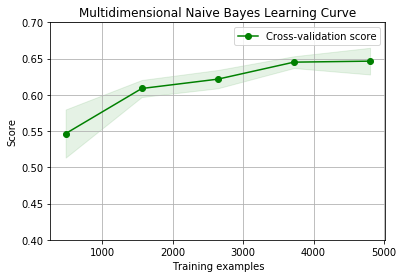

In [22]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, train_sizes=np.linspace(.1, 1.0, 5), training_curve=False):
    plt.figure()
    plt.title(title)
    if not training_curve:
        plt.ylim((0.4, 0.7))
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve( estimator, X, y, cv=None, n_jobs=1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    if training_curve:
        plt.fill_between(train_sizes, train_scores_mean-train_scores_std, \
                         train_scores_mean+train_scores_std, alpha=0.1, color="r")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    
    plt.fill_between(train_sizes, test_scores_mean-test_scores_std,test_scores_mean+test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(classifier, "Multidimensional Naive Bayes Learning Curve", features, labels)

#### Prédiction sur les données d'apprentissage 

In [23]:
from sklearn import metrics

nb_predict_train = classifier.predict(features)
#check accuracy
print("Accuracy: {:0.4f}".format(metrics.accuracy_score(labels, nb_predict_train)))
del features

Accuracy: 0.9986


In [24]:
#print confusion matrix
print("{}".format(metrics.confusion_matrix(labels, nb_predict_train, 
                                           labels=[1,-1, 0])))

print("{}".format(metrics.classification_report(labels, nb_predict_train, 
                                                labels=[1, -1, 0])))

[[2685    0    7]
 [   1 1021    2]
 [   0    0 3489]]
             precision    recall  f1-score   support

          1       1.00      1.00      1.00      2692
         -1       1.00      1.00      1.00      1024
          0       1.00      1.00      1.00      3489

avg / total       1.00      1.00      1.00      7205



### Prédire en utilisant le modèle
***

#### Importer test set

In [25]:
t_df = pd.read_csv('/data/test/actual/test_B_labeled.tsv', sep='\t', header=None)
print(t_df.shape)

(8902, 4)


In [26]:
t_df = t_df[t_df[3] != 'Not Available']
actual_labels = t_df[2]
actual_labels = actual_labels.map(mapper)
print(t_df.shape)
print(actual_labels.shape)

(7584, 4)
(7584,)


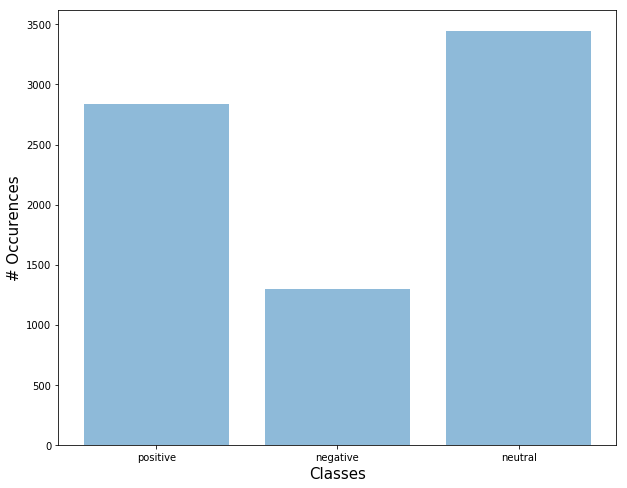

In [27]:
y = [len(t_df[t_df[2] == i]) for i in ['positive', 'negative', 'neutral']]
x = ['positive', 'negative', 'neutral']
x_pos = range(len(x))

plt.figure(figsize=(10,8))
plt.bar(x_pos, y, alpha=0.5)
plt.xticks(x_pos, x)
plt.ylabel('# Occurences').set_size(15)
plt.xlabel('Classes').set_size(15)

#### Pré-traiter les tweets de l'ensemble de données de test

In [28]:
raw_tweets_test = t_df[3]

In [29]:
raw_tweets_test = [replaceSlangs(tweet, slangs) for tweet in raw_tweets_test]
raw_tweets_test = [replace_apostrophe(tweet, apos) for tweet in raw_tweets_test]
raw_tweets_test = [subsEmoticon(tweet, dict) for tweet in raw_tweets_test]
raw_tweets_test = [handle_negation(tweet) for tweet in raw_tweets_test] #negation
lemmatized_tweets_test = [lemma(tweet) for tweet in raw_tweets_test]
clean_tweets_test = [remove_hashtags(tweet) for tweet in lemmatized_tweets_test]
preprocessed_tweets_test = [preprocess(tweet) for tweet in clean_tweets_test]
final_tweets_test = [rem_stop(tweet) for tweet in preprocessed_tweets_test]
t_df[3] = final_tweets_test

del raw_tweets_test, lemmatized_tweets_test, preprocessed_tweets_test

In [30]:
t_df.head()

,0,1,2,3
2,282031301962395648,T14111200,neutral,dec st know asnot thenot endnot ofnot thenot w...
3,11975,SM112166,negative,yar quite clever aft many guess lor got ask br...
4,136592,LJ112295,negative,yeah thin lizzy hate informercial
5,253421252956545024,T13114433,neutral,mt deir ezzor ali bashar altheeb wa martyred w...
6,220880422320603137,T14114138,negative,hate life seenot younot atnot thenot roskilden...


#### Créer le features vector

In [31]:
test_count_features = count_vectorizer.transform(final_tweets_test)
test_count_features = scipy.sparse.csr_matrix(test_count_features)
print (test_count_features.shape)


test_tfidf_features = tfidf_vectorizer.transform(final_tweets_test)
test_tfidf_features = scipy.sparse.csr_matrix(test_tfidf_features)
print (test_tfidf_features.shape)

(7584, 143605)
(7584, 143605)


In [32]:
test_features = scipy.sparse.hstack([test_count_features, test_tfidf_features])
print (test_features.shape)

del test_count_features, test_tfidf_features

(7584, 287210)


#### Prédire les étiquettes en utilisant le modèle

In [33]:
predicted_labels = classifier.predict(test_features)

### Évaluer le modèle
***

#### Accuracy

In [34]:
print('Accuracy: {:0.2f}%'.format(metrics.accuracy_score(actual_labels, predicted_labels) * 100))

Accuracy: 64.33%


In [35]:
# Rapport de classification
print('{}'.format(metrics.classification_report(actual_labels, predicted_labels)))

             precision    recall  f1-score   support

         -1       0.68      0.20      0.31      1296
          0       0.59      0.88      0.71      3448
          1       0.76      0.55      0.64      2840

avg / total       0.67      0.64      0.62      7584



Voir [Confusion Matrix](https://fr.wikipedia.org/wiki/Matrice_de_confusion) 


In [36]:
# Confusion Matrix
print('{}\n'.format(metrics.confusion_matrix(actual_labels, predicted_labels, labels=[1,-1,0])))
#-------------------- F1-score --------------------
print("\x1b[31m\" macro f1 score \"\x1b[0m")
print('{}\n'.format(metrics.f1_score(actual_labels, predicted_labels, average='macro')))
print("\x1b[31m\" micro f1 score \"\x1b[0m")
print('{}\n'.format(metrics.f1_score(actual_labels, predicted_labels, average='micro')))

#-------------------- precision-score --------------------
print("\x1b[31m\" macro precision score \"\x1b[0m")
print('{}\n'.format(metrics.precision_score(actual_labels, predicted_labels, average='macro')))
print("\x1b[31m\" micro precision score \"\x1b[0m")
print('{}\n'.format(metrics.precision_score(actual_labels, predicted_labels, average='micro')))

#-------------------- recall-score --------------------
print("\x1b[31m\" macro recall score \"\x1b[0m")
print('{}\n'.format(metrics.recall_score(actual_labels, predicted_labels, average='macro')))
print("\x1b[31m\" micro recall score \"\x1b[0m")
print('{}\n'.format(metrics.recall_score(actual_labels, predicted_labels, average='micro')))

[[1572   52 1216]
 [ 171  260  865]
 [ 331   70 3047]]

" macro f1 score "
0.5534283519372044

" micro f1 score "
0.64332805907173

" macro precision score "
0.6775908936916379

" micro precision score "
0.64332805907173

" macro recall score "
0.5459463689222884

" micro recall score "
0.64332805907173



### Comparaison avec les 5 meilleures équipes du subtask B

Nous comparons notre score avec les autres équipes de l'atelier. Les résultats sont tirés du document joint:
[Final report SemEval 2014 Subtask 9](http://www.aclweb.org/anthology/S14-2009)

|Team|Accuracy (Macro Averaged)| Accuracy (Micro Averaged)|
|----|-------------------------|--------------------------|
|TeamX|65.63%|69.99%|
|coooolll|63.23%|70.51%|
|RTRGO|63.08%|70.15%|
|NRC-Canada|67.62%|71.37%|
|TUGAS|63.89%|68.84%|
|**_ME_**|_63.67%_|_67.44%_|
| | |***classement : 10 / 50***|
 

# <font color='red'> Analyse des modèles de classification: 

|Model|Macro Averaging| Micro Averaging|
|-----|---------------|----------------|
|NB (without Lexicons)|51.17%|60.28%|
|NB (with Lexicons)|46.00%|59.53%|
|LR (without Lexicons)|55.42%|64.39%|